# Results - Classification on experimental data
This notebook is the primary source of plots and tables for the classificationn part of the thesis, 
with the goal of keeping every table and figure as standardized as possible. 
## Questions
* Descriptive statistics
    - Should descriptive statistics of the simulated data be included?\
    If so, how much? And should it be included for each fold in the k-fold cross-validation?
* Classification results
    - Breakdown of results based on event type? Single, double, close double?
    Reasonable to include in order to confirm the assumption that close doubles are the
    most difficult event type to classify correctly in simulated data
    Random state is included, so should be simple to reproduce the indices


## Handy links
* [matplotlib-plots to latex](https://timodenk.com/blog/exporting-matplotlib-plots-to-latex/)
* [Robert's thesis df output](https://github.com/ATTPC/VAE-event-classification/blob/master/src/make_classification_table.py)

In [62]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from master_scripts.data_functions import *
from master_scripts.analysis_functions import *
import tensorflow as tf
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np

THESIS_PATH = "../../../master_thesis/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
# Load experimental set and normalize
repo_root = get_git_root()
events, images_real = import_real_data(repo_root + "data/real/anodedata_500k.txt") # images not normalized

# normalize each event type separately
descriptors = list(set([event['event_descriptor'] for event in events.values()]))
image_indices = {}
for d in descriptors:
    img_idx = np.array([event['image_idx'] for event in events.values() if event['event_descriptor'] == d])
    # append labeled doubles to decays for normalization.
    if d == 16:
        image_indices[2] = np.concatenate((image_indices[2], img_idx), axis=0)
    else:
        image_indices[d] = img_idx
for indices in image_indices.values():
    images_real[indices] = normalize_image_data(images_real[indices])

In [91]:
# GLOBAL VARIABLES FOR PLOT
HIST_DICT = {}

In [92]:
def classify(model, images, events, threshold=0.5):
    # Get prediction and make class labels based on threshold of 0.5
    y_out = model.predict(images)
    y_pred = (y_out > threshold).astype(int)
    for event_id in events.keys():
        if y_pred[events[event_id]['image_idx']] == 0:
            events[event_id]['event_class'] = "single"
        else:
            events[event_id]['event_class'] = "double"

    return events

def classification_metrics(model, images, events, name, threshold=0.5):
    # Get prediction and make class labels based on threshold of 0.5
    y_out = model.predict(images)
    y_pred = (y_out > threshold).astype(int)
    for event_id in events.keys():
        if y_pred[events[event_id]['image_idx']] == 0:
            events[event_id]['event_class'] = "single"
        else:
            events[event_id]['event_class'] = "double"
            
    descriptors = list(set([event['event_descriptor'] for event in events.values()]))
    
    desc_class = {'single': [], 'double': []}
    for event in events.values():
        desc_class[event['event_class']].append(event['event_descriptor'])
    
    translate_descriptor = {
        1: "Implant",
        2: "Decay",
        3: "implant + Decay",
        4: "Light ion",
        5: "Implant + Light Ion",
        6: "Decay + Light Ion",
        7: "Implant + Decay + Light Ion",
        8: "Double (time)",
        9: "Implant + Double (time)",
        10: "Decay + Double (time)",
        11: "Implant + Decay + Double (time)",
        12: "Light ion + Double (time)",
        13: "Implant + Light Ion + Double (time)",
        14: "Decay + Light ion + Double (time)",
        15: "Implant + Decay + Light Ion + Double (time)",
        16: "Double (space)",
        17: "Implant + Double (space)",
        18: "Decay + Double (space)"
    }
    
    results = {}
    for d in descriptors:
        num_s = desc_class['single'].count(d)
        num_d = desc_class['double'].count(d)
        tot = num_s + num_d
        norm_s = num_s / tot
        norm_d = num_d / tot
        results[translate_descriptor[d]] = [
            num_s,
            num_d,
            norm_s,
            norm_d
        ]
    
    cols = ["Predicted single", "Predicted double", "Normalized single", "Normalized double"]
    df = pd.DataFrame.from_dict(data=results, orient='index', columns=cols)
    
    # histogram dict addition
    decays = [e['image_idx'] for e in events.values() if e['event_descriptor'] == 2]
    single = (y_out[decays] <= 0.5).reshape(len(decays))
    double = y_out[decays] > 0.5
    img_sum = np.sum(images_real[decays], axis=(1,2)).reshape(len(decays))
    pixel_sums = np.linspace(0, 20, 50)
    counts, bins = np.histogram(img_sum[single], bins=pixel_sums)
    name = name + "_i"
    if name in HIST_DICT:
        if name + "i" in HIST_DICT:
            HIST_DICT[name + "ii"] = [bins, counts]
        else:
            HIST_DICT[name + "i"] = [bins, counts]
    else:
        HIST_DICT[name] = [bins, counts]
    
    return df


In [93]:
# Experiment id's
experiments_nomod = {
    'logistic': "1bc7c249cd14",
    'dense': "301dfb138506",
    'cnn': "7f2dd7f1d24c",
    'pretrained': "94685622cb2d",
    'custom': "e8772df34916",
}
experiments_pixelmod = {
    'logistic': "292d34a807ea",
    'dense': "48203947802a",
    'cnn': "35afebe71164",
    'pretrained': "6aebbcd131d1",
    'custom': "05b90ffdfc3c",
}
experiments_imbalanced = {
    'logistic': "9380b00c72f5",
    'dense': "851d3c6f60c8",
    'cnn': "d34250436c72",
    'pretrained': "dd1df8beb788",
    'custom': "28fd163fc0c1",
}

# Pre-processed simulated data - no additional modifications
This is the basic metrics for all the models trained on simulated data.
The basic pre-processing includes formatting and min-max normalization.

## Logistic regression

In [94]:
# Load logistic regression experiment
log_ex_id = experiments_nomod['logistic']
log_ex = load_experiment(log_ex_id)

# Load model and predict
log_model = tf.keras.models.load_model(repo_root + "models/" + log_ex_id + ".h5", compile=False)
log_test = classification_metrics(log_model, images_real.reshape(images_real.shape[0], 256), events, "log_test")
del log_model #No longer needed, clear memory just in case.

## Small dense network

In [95]:
# Load logistic regression experiment
dense_ex_id = experiments_nomod['dense']
dense_ex = load_experiment(dense_ex_id)
dense_model = tf.keras.models.load_model(repo_root + "models/" + dense_ex_id + ".h5", compile=False)
dense_test = classification_metrics(dense_model, images_real.reshape(images_real.shape[0], 256), events, "dense_test")
del dense_model

## Small CNN

In [96]:
# Load logistic regression experiment
cnn_ex_id = experiments_nomod['cnn']
cnn_ex = load_experiment(cnn_ex_id)
cnn_model = tf.keras.models.load_model(repo_root + "models/" + cnn_ex_id + ".h5", compile=False)
cnn_test = classification_metrics(cnn_model, images_real, events, "cnn_test")
del cnn_model

## Pretrained - VGG
As an additional baseline for performance, we include a pretrained SOTA network
where trained on the ImageNet database.

Due to the size of our detector images (16x16) compared with the size the VGG network is
designed for, we cannot use all layers in the VGG network. This stems from the use of max-pooling
which effectively reduces the image size to half (8x8) each time the input is passed through such a
layer. At some point our input is too small to pass through to the rest of the network.
We therefore cut the network at the point where this becomes and issue.
Alternatively, one could possibly keep the depth but remove max-pooling layers.


It is common in transfer learning to use a pretrained model which is then fine-tuned on task-specific data.
You can then view the pretraining as a step to get a "good" initialization for weights.

In [97]:
# Load pretrained regression experiment
pretrained_ex_id = experiments_nomod['pretrained']
pretrained_ex = load_experiment(pretrained_ex_id)

pretrained_model = tf.keras.models.load_model(repo_root + "models/" + pretrained_ex_id + ".h5", compile=False)
pretrained_test = classification_metrics(pretrained_model, np.concatenate((images_real, images_real, images_real), axis=-1), events, "pretrained_test")
del pretrained_model

## Custom model

In [98]:
# Load custom classification experiment
custom_ex_id = experiments_nomod['custom']
custom_ex = load_experiment(custom_ex_id)
custom_model = tf.keras.models.load_model(repo_root + "models/" + custom_ex_id + ".h5", compile=False)
custom_test = classification_metrics(custom_model, images_real, events, "custom_test")
predictions = custom_model.predict(normalize_image_data(images_real))
del custom_model

## Combine the metrics into one table
We use the standard deviation in the folds as an error measure, and report the mean classification f1_score.

In [99]:
all_decays = pd.DataFrame.from_dict(
    data={
        'Logistic': log_test.iloc[1],
        'Dense': dense_test.iloc[1],
        'CNN': cnn_test.iloc[1],
        'Pretrained': pretrained_test.iloc[1],
        'Custom': custom_test.iloc[1],
    },
    orient='index'
)

all_labeled_doubles = pd.DataFrame.from_dict(
        data={
        'Logistic': log_test.iloc[-1],
        'Dense': dense_test.iloc[-1],
        'CNN': cnn_test.iloc[-1],
        'Pretrained': pretrained_test.iloc[-1],
        'Custom': custom_test.iloc[-1],
    },
    orient='index'
)

display(all_decays)
display(all_labeled_doubles)

,Predicted single,Predicted double,Normalized single,Normalized double
Logistic,95565.0,164582.0,0.367350,0.632650
Dense,92920.0,167227.0,0.357183,0.642817
CNN,62359.0,197788.0,0.239707,0.760293
Pretrained,53837.0,206310.0,0.206948,0.793052
Custom,20219.0,239928.0,0.077721,0.922279


,Predicted single,Predicted double,Normalized single,Normalized double
Logistic,0.0,17.0,0.0,1.0
Dense,0.0,17.0,0.0,1.0
CNN,17.0,0.0,1.0,0.0
Pretrained,0.0,17.0,0.0,1.0
Custom,0.0,17.0,0.0,1.0


# Pre-processed simulated data - Pixel modified
The basic pre-processing includes formatting and min-max normalization.
Additionally, the data has had the top and bottom lines of pixels set to 0, plus
one pixel inside the detector permanently 0 (which idx again?).

## Logistic regression

In [100]:
# Load logistic regression experiment
log_ex_id = experiments_pixelmod['logistic']
log_ex = load_experiment(log_ex_id)

# Load model
log_model = tf.keras.models.load_model(repo_root + "models/" + log_ex_id + ".h5", compile=False)
log_test_pmod = classification_metrics(log_model, images_real.reshape(images_real.shape[0], 256), events, "log_test")
del log_model #No longer needed, clear memory just in case.

## Small dense network

In [101]:
# Load logistic regression experiment
dense_ex_id = experiments_pixelmod['dense']
dense_ex = load_experiment(dense_ex_id)
dense_model = tf.keras.models.load_model(repo_root + "models/" + dense_ex_id + ".h5", compile=False)
dense_test_pmod = classification_metrics(dense_model, images_real.reshape(images_real.shape[0], 256), events, "dense_test")
del dense_model

## Small CNN

In [102]:
# Load logistic regression experiment
cnn_ex_id = experiments_pixelmod['cnn']
cnn_ex = load_experiment(cnn_ex_id)
cnn_model = tf.keras.models.load_model(repo_root + "models/" + cnn_ex_id + ".h5", compile=False)
cnn_test_pmod = classification_metrics(cnn_model, images_real, events, "cnn_test")
del cnn_model

## Pretrained - VGG
As an additional baseline for performance, we include a pretrained SOTA network
where trained on the ImageNet database.

Due to the size of our detector images (16x16) compared with the size the VGG network is
designed for, we cannot use all layers in the VGG network. This stems from the use of max-pooling
which effectively reduces the image size to half (8x8) each time the input is passed through such a
layer. At some point our input is too small to pass through to the rest of the network.
We therefore cut the network at the point where this becomes and issue.
Alternatively, one could possibly keep the depth but remove max-pooling layers.

In [103]:
# Load logistic regression experiment
pretrained_ex_id = experiments_pixelmod['pretrained']
pretrained_ex = load_experiment(pretrained_ex_id)
pretrained_model = tf.keras.models.load_model(repo_root + "models/" + pretrained_ex_id + ".h5", compile=False)
pretrained_test_pmod = classification_metrics(pretrained_model, np.concatenate((images_real, images_real, images_real), axis=-1), events, "pretrained_test")
del pretrained_model

## Custom model

In [104]:
# Load custom classification experiment
custom_ex_id = experiments_pixelmod['custom']
custom_ex = load_experiment(custom_ex_id)
custom_model = tf.keras.models.load_model(repo_root + "models/" + custom_ex_id + ".h5", compile=False)
custom_test_pmod = classification_metrics(custom_model, images_real, events, "custom_test")
del custom_model

## Combine the metrics into one table
We use the standard deviation in the folds as an error measure, and report the mean classification f1_score.

In [105]:
all_decays_pmod = pd.DataFrame.from_dict(
    data={
        'Logistic': log_test_pmod.iloc[1],
        'Dense': dense_test_pmod.iloc[1],
        'CNN': cnn_test_pmod.iloc[1],
        'Pretrained': pretrained_test_pmod.iloc[1],
        'Custom': custom_test_pmod.iloc[1],
    },
    orient='index'
)

all_labeled_doubles_pmod = pd.DataFrame.from_dict(
        data={
        'Logistic': log_test_pmod.iloc[-1],
        'Dense': dense_test_pmod.iloc[-1],
        'CNN': cnn_test_pmod.iloc[-1],
        'Pretrained': pretrained_test_pmod.iloc[-1],
        'Custom': custom_test_pmod.iloc[-1],
    },
    orient='index'
)

display(all_decays_pmod)
display(all_labeled_doubles_pmod)

,Predicted single,Predicted double,Normalized single,Normalized double
Logistic,97629.0,162518.0,0.375284,0.624716
Dense,97498.0,162649.0,0.374780,0.625220
CNN,55512.0,204635.0,0.213387,0.786613
Pretrained,48449.0,211698.0,0.186237,0.813763
Custom,17859.0,242288.0,0.068650,0.931350


,Predicted single,Predicted double,Normalized single,Normalized double
Logistic,0.0,17.0,0.0,1.0
Dense,0.0,17.0,0.0,1.0
CNN,0.0,17.0,0.0,1.0
Pretrained,0.0,17.0,0.0,1.0
Custom,0.0,17.0,0.0,1.0


# Pre-processed simulated data - Pixel modified and imbalanced
The basic pre-processing includes formatting and min-max normalization.
Additionally, the data has had the top and bottom lines of pixels set to 0, plus
one pixel inside the detector permanently 0 (which idx again?).

This dataset has also been purposefully imbalanced to mimic the properties of experimental data
where doubles in space are expected to be rare.

## Logistic regression

In [106]:
# Load logistic regression experiment
log_ex_id = experiments_imbalanced['logistic']
log_ex = load_experiment(log_ex_id)

# Load model
log_model = tf.keras.models.load_model(repo_root + "models/" + log_ex_id + ".h5", compile=False)
log_test_imbalanced = classification_metrics(log_model, images_real.reshape(images_real.shape[0], 256), events, "log_test")
del log_model #No longer needed, clear memory just in case.

## Small dense network

In [107]:
# Load logistic regression experiment
dense_ex_id = experiments_imbalanced['dense']
dense_ex = load_experiment(dense_ex_id)
dense_model = tf.keras.models.load_model(repo_root + "models/" + dense_ex_id + ".h5", compile=False)
dense_test_imbalanced = classification_metrics(dense_model, images_real.reshape(images_real.shape[0], 256), events, "dense_test")
del dense_model

## Small CNN

In [108]:
# Load logistic regression experiment
cnn_ex_id = experiments_imbalanced['cnn']
cnn_ex = load_experiment(cnn_ex_id)
cnn_model = tf.keras.models.load_model(repo_root + "models/" + cnn_ex_id + ".h5", compile=False)
cnn_test_imbalanced = classification_metrics(cnn_model, images_real, events, "cnn_test")
del cnn_model

## Pretrained - VGG
As an additional baseline for performance, we include a pretrained SOTA network
where trained on the ImageNet database.

Due to the size of our detector images (16x16) compared with the size the VGG network is
designed for, we cannot use all layers in the VGG network. This stems from the use of max-pooling
which effectively reduces the image size to half (8x8) each time the input is passed through such a
layer. At some point our input is too small to pass through to the rest of the network.
We therefore cut the network at the point where this becomes and issue.
Alternatively, one could possibly keep the depth but remove max-pooling layers.

In [109]:
# Load logistic regression experiment
pretrained_ex_id = experiments_imbalanced['pretrained']
pretrained_ex = load_experiment(pretrained_ex_id)
pretrained_model = tf.keras.models.load_model(repo_root + "models/" + pretrained_ex_id + ".h5", compile=False)
pretrained_test_imbalanced = classification_metrics(pretrained_model, np.concatenate((images_real, images_real, images_real), axis=-1), events, "pretrained_test")
del pretrained_model

## Custom model

In [110]:
# Load custom classification experiment
custom_ex_id = experiments_imbalanced['custom']
custom_ex = load_experiment(custom_ex_id)
custom_model = tf.keras.models.load_model(repo_root + "models/" + custom_ex_id + ".h5", compile=False)
custom_test_imbalanced = classification_metrics(custom_model, images_real, events, "custom_test")
del custom_model

## Combine the metrics into one table
We use the standard deviation in the folds as an error measure, and report the mean classification f1_score.

In [111]:
all_decays_imbalanced = pd.DataFrame.from_dict(
    data={
        'Logistic': log_test_imbalanced.iloc[1],
        'Dense': dense_test_imbalanced.iloc[1],
        'CNN': cnn_test_imbalanced.iloc[1],
        'Pretrained': pretrained_test_imbalanced.iloc[1],
        'Custom': custom_test_imbalanced.iloc[1],
    },
    orient='index'
)

all_labeled_doubles_imbalanced = pd.DataFrame.from_dict(
        data={
        'Logistic': log_test_imbalanced.iloc[-1],
        'Dense': dense_test_imbalanced.iloc[-1],
        'CNN': cnn_test_imbalanced.iloc[-1],
        'Pretrained': pretrained_test_imbalanced.iloc[-1],
        'Custom': custom_test_imbalanced.iloc[-1],
    },
    orient='index'
)

display(all_decays_imbalanced)
display(all_labeled_doubles_imbalanced)


,Predicted single,Predicted double,Normalized single,Normalized double
Logistic,139578.0,120569.0,0.536535,0.463465
Dense,139405.0,120742.0,0.535870,0.464130
CNN,58870.0,201277.0,0.226295,0.773705
Pretrained,58534.0,201613.0,0.225004,0.774996
Custom,29441.0,230706.0,0.113171,0.886829


,Predicted single,Predicted double,Normalized single,Normalized double
Logistic,0.0,17.0,0.000000,1.000000
Dense,0.0,17.0,0.000000,1.000000
CNN,4.0,13.0,0.235294,0.764706
Pretrained,0.0,17.0,0.000000,1.000000
Custom,0.0,17.0,0.000000,1.000000


# Tables

In [112]:
rows = all_decays_imbalanced.index
exp_str_array = np.zeros((5, 6), dtype=object)
for i,row in enumerate(rows):
    exp_str_array[i, 0] = r"$\underset{{\num{{ {:.0f} }}  }}{{\num{{ {:.3f} }} }}$".format(
        all_decays.loc[row]["Predicted single"],
        all_decays.loc[row]["Normalized single"],
    )
    exp_str_array[i, 1] = r"$\underset{{\num{{ {:.0f} }}  }}{{\num{{ {:.3f} }} }}$".format(
        all_decays.loc[row]["Predicted double"],
        all_decays.loc[row]["Normalized double"],
    )
    exp_str_array[i, 2] = r"$\underset{{\num{{ {:.0f} }}  }}{{\num{{ {:.3f} }} }}$".format(
        all_decays_pmod.loc[row]["Predicted single"],
        all_decays_pmod.loc[row]["Normalized single"],
    )
    exp_str_array[i, 3] = r"$\underset{{\num{{ {:.0f} }}  }}{{\num{{ {:.3f} }} }}$".format(
        all_decays_pmod.loc[row]["Predicted double"],
        all_decays_pmod.loc[row]["Normalized double"],
    )
    exp_str_array[i, 4] = r"$\underset{{\num{{ {:.0f} }}  }}{{\num{{ {:.3f} }} }}$".format(
        all_decays_imbalanced.loc[row]["Predicted single"],
        all_decays_imbalanced.loc[row]["Normalized single"],
    )
    exp_str_array[i, 5] = r"$\underset{{\num{{ {:.0f} }}  }}{{\num{{ {:.3f} }} }}$".format(
        all_decays_imbalanced.loc[row]["Predicted double"],
        all_decays_imbalanced.loc[row]["Normalized double"],
    )

cols = ["Single (a)","Double (a)", "Single (b)", "Double (b)", "Single (c)","Double (c)"]
exp_df = pd.DataFrame(exp_str_array, columns=cols, index=rows)
display(exp_df)

section_path = "chapters/results/figures/"
fname = THESIS_PATH + section_path + "classification_experimental_ratios.tex"
caption = """
Decay event classification on experimental data, with models trained on:
a) unmodified data, b) data where specific pixels are set to zero to mimic
'dead' pixels in experimental data, and c) same as b) and imbalanced to mimic experimental data.
The numbers are shown as the normalized ratio of predicted event type, with the actual amount of
events predicted of that type below.
"""
label = "tab:classification-experimental-ratios"
with open(fname, "w") as fp:
    pd.set_option('display.max_colwidth', -1)
    exp_df.to_latex(fp, escape=False, caption=caption, label=label, index=True)


,Single (a),Double (a),Single (b),Double (b),Single (c),Double (c)
Logistic,$\underset{\num{ 95565 } }{\num{ 0.367 } }$,$\underset{\num{ 164582 } }{\num{ 0.633 } }$,$\underset{\num{ 97629 } }{\num{ 0.375 } }$,$\underset{\num{ 162518 } }{\num{ 0.625 } }$,$\underset{\num{ 139578 } }{\num{ 0.537 } }$,$\underset{\num{ 120569 } }{\num{ 0.463 } }$
Dense,$\underset{\num{ 92920 } }{\num{ 0.357 } }$,$\underset{\num{ 167227 } }{\num{ 0.643 } }$,$\underset{\num{ 97498 } }{\num{ 0.375 } }$,$\underset{\num{ 162649 } }{\num{ 0.625 } }$,$\underset{\num{ 139405 } }{\num{ 0.536 } }$,$\underset{\num{ 120742 } }{\num{ 0.464 } }$
CNN,$\underset{\num{ 62359 } }{\num{ 0.240 } }$,$\underset{\num{ 197788 } }{\num{ 0.760 } }$,$\underset{\num{ 55512 } }{\num{ 0.213 } }$,$\underset{\num{ 204635 } }{\num{ 0.787 } }$,$\underset{\num{ 58870 } }{\num{ 0.226 } }$,$\underset{\num{ 201277 } }{\num{ 0.774 } }$
Pretrained,$\underset{\num{ 53837 } }{\num{ 0.207 } }$,$\underset{\num{ 206310 } }{\num{ 0.793 } }$,$\underset{\num{ 48449 } }{\num{ 0.186 } }$,$\underset{\num{ 211698 } }{\num{ 0.814 } }$,$\underset{\num{ 58534 } }{\num{ 0.225 } }$,$\underset{\num{ 201613 } }{\num{ 0.775 } }$
Custom,$\underset{\num{ 20219 } }{\num{ 0.078 } }$,$\underset{\num{ 239928 } }{\num{ 0.922 } }$,$\underset{\num{ 17859 } }{\num{ 0.069 } }$,$\underset{\num{ 242288 } }{\num{ 0.931 } }$,$\underset{\num{ 29441 } }{\num{ 0.113 } }$,$\underset{\num{ 230706 } }{\num{ 0.887 } }$


In [113]:
rows = all_labeled_doubles_imbalanced.index
exp_str_array = np.zeros((5, 6), dtype=object)
for i,row in enumerate(rows):
    exp_str_array[i, 0] = r"$\underset{{\num{{ {:.0f} }}  }}{{\num{{ {:.3f} }} }}$".format(
        all_labeled_doubles.loc[row]["Predicted single"],
        all_labeled_doubles.loc[row]["Normalized single"],
    )
    exp_str_array[i, 1] = r"$\underset{{\num{{ {:.0f} }}  }}{{\num{{ {:.3f} }} }}$".format(
        all_labeled_doubles.loc[row]["Predicted double"],
        all_labeled_doubles.loc[row]["Normalized double"],
    )
    exp_str_array[i, 2] = r"$\underset{{\num{{ {:.0f} }}  }}{{\num{{ {:.3f} }} }}$".format(
        all_labeled_doubles_pmod.loc[row]["Predicted single"],
        all_labeled_doubles_pmod.loc[row]["Normalized single"],
    )
    exp_str_array[i, 3] = r"$\underset{{\num{{ {:.0f} }}  }}{{\num{{ {:.3f} }} }}$".format(
        all_labeled_doubles_pmod.loc[row]["Predicted double"],
        all_labeled_doubles_pmod.loc[row]["Normalized double"],
    )
    exp_str_array[i, 4] = r"$\underset{{\num{{ {:.0f} }}  }}{{\num{{ {:.3f} }} }}$".format(
        all_labeled_doubles_imbalanced.loc[row]["Predicted single"],
        all_labeled_doubles_imbalanced.loc[row]["Normalized single"],
    )
    exp_str_array[i, 5] = r"$\underset{{\num{{ {:.0f} }}  }}{{\num{{ {:.3f} }} }}$".format(
        all_labeled_doubles_imbalanced.loc[row]["Predicted double"],
        all_labeled_doubles_imbalanced.loc[row]["Normalized double"],
    )

cols = ["Single (a)","Double (a)", "Single (b)", "Double (b)", "Single (c)","Double (c)"]
exp_df = pd.DataFrame(exp_str_array, columns=cols, index=rows)
display(exp_df)

section_path = "chapters/results/figures/"
fname = THESIS_PATH + section_path + "classification_experimental_labeled_doubles.tex"
caption = """
Decay event classification on 17 labeled samples of experimental data. The 17 samples are all
labeled as double events. Models are trained on simulated data with a varying degree of modification:
a) unmodified data, b) data where specific pixels are set to zero to mimic
'dead' pixels in experimental data, and c) same as b) and imbalanced to mimic experimental data.
The numbers are shown as the normalized ratio of predicted event type, with the actual amount of
events predicted of that type below.
"""
label = "tab:classification-experimental-labeled-doubles"
with open(fname, "w") as fp:
    pd.set_option('display.max_colwidth', -1)
    exp_df.to_latex(fp, escape=False, caption=caption, label=label, index=True)

,Single (a),Double (a),Single (b),Double (b),Single (c),Double (c)
Logistic,$\underset{\num{ 0 } }{\num{ 0.000 } }$,$\underset{\num{ 17 } }{\num{ 1.000 } }$,$\underset{\num{ 0 } }{\num{ 0.000 } }$,$\underset{\num{ 17 } }{\num{ 1.000 } }$,$\underset{\num{ 0 } }{\num{ 0.000 } }$,$\underset{\num{ 17 } }{\num{ 1.000 } }$
Dense,$\underset{\num{ 0 } }{\num{ 0.000 } }$,$\underset{\num{ 17 } }{\num{ 1.000 } }$,$\underset{\num{ 0 } }{\num{ 0.000 } }$,$\underset{\num{ 17 } }{\num{ 1.000 } }$,$\underset{\num{ 0 } }{\num{ 0.000 } }$,$\underset{\num{ 17 } }{\num{ 1.000 } }$
CNN,$\underset{\num{ 17 } }{\num{ 1.000 } }$,$\underset{\num{ 0 } }{\num{ 0.000 } }$,$\underset{\num{ 0 } }{\num{ 0.000 } }$,$\underset{\num{ 17 } }{\num{ 1.000 } }$,$\underset{\num{ 4 } }{\num{ 0.235 } }$,$\underset{\num{ 13 } }{\num{ 0.765 } }$
Pretrained,$\underset{\num{ 0 } }{\num{ 0.000 } }$,$\underset{\num{ 17 } }{\num{ 1.000 } }$,$\underset{\num{ 0 } }{\num{ 0.000 } }$,$\underset{\num{ 17 } }{\num{ 1.000 } }$,$\underset{\num{ 0 } }{\num{ 0.000 } }$,$\underset{\num{ 17 } }{\num{ 1.000 } }$
Custom,$\underset{\num{ 0 } }{\num{ 0.000 } }$,$\underset{\num{ 17 } }{\num{ 1.000 } }$,$\underset{\num{ 0 } }{\num{ 0.000 } }$,$\underset{\num{ 17 } }{\num{ 1.000 } }$,$\underset{\num{ 0 } }{\num{ 0.000 } }$,$\underset{\num{ 17 } }{\num{ 1.000 } }$


## Fraction of predicted single events for each model, as a function of total pixel intensity
These plots serve as another view of where the predictions of single events happen.

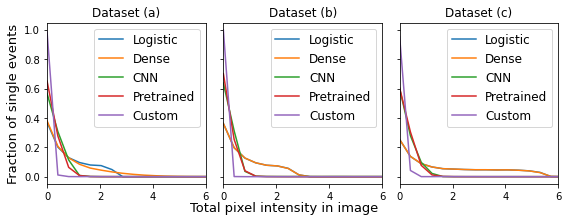

In [151]:
key_translator = {
    'log_test_i': 'Logistic',
    'dense_test_i': 'Dense',
    'cnn_test_i': 'CNN',
    'pretrained_test_i': 'Pretrained',
    'custom_test_i': 'Custom',
    'log_test_ii': 'Logistic',
    'dense_test_ii': 'Dense',
    'cnn_test_ii': 'CNN',
    'pretrained_test_ii': 'Pretrained',
    'custom_test_ii': 'Custom',
    'log_test_iii': 'Logistic',
    'dense_test_iii': 'Dense',
    'cnn_test_iii': 'CNN',
    'pretrained_test_iii': 'Pretrained',
    'custom_test_iii': 'Custom',
}

fig, ax = plt.subplots(1,3,figsize=(8, 3), sharex=True, sharey=True)
for k, v in HIST_DICT.items():
    bins = v[0]
    counts = v[1]
    if k.endswith('_i'):
        ax[0].plot(bins[:-1], counts/sum(counts), label=key_translator[k])
    if k.endswith('_ii'):
        ax[1].plot(bins[:-1], counts/sum(counts), label=key_translator[k])
    if k.endswith('_iii'):
        ax[2].plot(bins[:-1], counts/sum(counts), label=key_translator[k])

ax[0].set_ylabel("Fraction of single events", fontsize=13)
ax[0].set_title("Dataset (a)")
ax[0].legend(fontsize=12)
ax[1].set_title("Dataset (b)")
ax[1].legend(fontsize=12)
ax[2].set_title("Dataset (c)")
ax[2].legend(fontsize=12)
ax[0].set_xlim(0, 6)
fig.text(0.5, 0, "Total pixel intensity in image", ha='center', fontsize=13)

fig.tight_layout()


section_path = "chapters/results/figures/"
fname = THESIS_PATH + section_path + "classification_experimental_single_fractions.pdf"
fig.savefig(fname, bbox_inches='tight')

# (OLD)Specific models with very reasonable amount of predicted doubles
Three models trained on imbalanced data showed a promising ratio of singles to doubles in their
predictions, with:
* Logistic regression - 2
* Dense network - 25
* Pretrained - 699

Coupled with the information that they specifically also predicted most or all of the labeled doubles
as doubles, we take a slightly deeper look into these three.

* Are they predicting the same events as doubles?
* Limited manual inspection of predicted doubles?

# (OLD)Check location of HIP for predicted doubles